In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [12]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx
from typing import List

from functools import partial
import os
import sys

jax.config.update('jax_platform_name', 'gpu')

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


np.random.seed(0)
jax.devices()

[cuda(id=0)]

In [13]:
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import get_diffrax_solver, make_stepsize_controller, simulate_steady_states
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation, compute_peaks, compute_adaptability_full


# Set up test circuits

In [14]:
def make_species_bound(species_unbound):
    return sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in species_unbound] for y in species_unbound])))


# RNA circuit settings
species_unbound = ['RNA_0', 'RNA_1', 'RNA_2']
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ['RNA_0']
species_output = ['RNA_1', 'RNA_2']
species_nonsignal = [s for s in species_unbound if s not in species_signal]
idxs_signal = np.array([species.index(s) for s in species_signal])
idxs_output = np.array([species.index(s) for s in species_output])
idxs_unbound = np.array([species.index(s) for s in species_unbound])
idxs_bound = np.array([species.index(s) for s in species_bound])
signal_onehot = np.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])

# Dynamic Simulation parameters
k_a = 0.00150958097
signal_target = 2
t0 = 0
t1 = 10
ts = np.linspace(t0, t1, 500)
tmax = 10
dt0 = 0.0005555558569638981
dt1_factor = 5
dt1 = dt0 * dt1_factor
max_steps = 16**4 * 10
use_sensitivity_func1 = False
sim_method = 'Dopri5'
stepsize_controller = 'adaptive'
threshold_steady_state = 0.01

# MC parameters
total_steps = 10
total_samples = 100
choose_max = 20
mutation_scale = 1
n_circuits_display = 30
N0 = 200
y00 = np.array([[N0] * len(species_unbound) + [0] * len(species_bound)]).astype(np.float32)
y00 = np.repeat(y00, repeats=total_samples, axis=0)

# Reactions
energies = np.random.rand(total_samples, len(species_unbound), len(species_unbound))
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
energies[np.tril_indices(len(species_unbound))] = energies[np.triu_indices(len(species_unbound))]
eqconstants = jax.vmap(equilibrium_constant_reparameterisation)(energies, y00[:, idxs_unbound])
forward_rates, reverse_rates = eqconstant_to_rates(eqconstants, k_a)
forward_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], forward_rates)))
forward_rates = forward_rates[0]
reverse_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], reverse_rates)))

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
], dtype=np.float64)

# Initialise simulations

In [15]:
sim_func = jax.jit(jax.vmap(
    partial(bioreaction_sim_dfx_expanded,
            t0=t0, t1=t1, dt0=dt0,
            forward_rates=forward_rates,
            inputs=inputs,
            outputs=outputs,
            solver=get_diffrax_solver(
                sim_method),
            saveat=dfx.SaveAt(
                ts=jnp.linspace(t0, t1, 500)),  # int(np.min([500, t1-t0]))))
            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1,
                                                         choice=stepsize_controller)
            )))
# sol_steady_states = jax.vmap(bioreaction_sim_dfx_expanded)(y00, reverse_rates)
# y01 = np.array(sol_steady_states.ys[:, -1])
# y01[:, np.array(idxs_signal)] = y01[:, np.array(idxs_signal)] * signal_target
# sol_signal = jax.vmap(bioreaction_sim_dfx_expanded)(y01, reverse_rates)

In [16]:
# adaptability, sensitivity, precision = jax.vmap(partial(compute_adaptability_full, idx_sig=idxs_signal[0], use_sensitivity_func1=use_sensitivity_func1))(
#     sol_steady_states.ys, sol_signal.ys)
# sensitivity = np.array(sensitivity)
# precision = np.array(precision)

# Monte Carlo iterations

In [17]:
def choose_next(params, sol, idxs_signal, idxs_output, use_sensitivity_func1: bool, choose_max: int, n_samples_per_parent: int, mutation_scale=0.1):
    """ Choose circuits with highest adaptability """

    ys0, ys1 = sol
    adaptability, sensitivity, precision = jax.vmap(partial(
        compute_adaptability_full, idx_sig=idxs_signal, use_sensitivity_func1=use_sensitivity_func1))(ys0, ys1)
    idxs_next = jnp.argsort(adaptability[:, idxs_output], axis=0)[-choose_max:]
    idxs_next = jnp.where(jnp.sort(jnp.nanmax(adaptability[:, idxs_output], axis=1))[
                          -choose_max:].min() < adaptability[:, idxs_output])[0]
    # summary_data = {}
    # summary_data['adaptability'] = adaptability
    return params[idxs_next], adaptability, sensitivity, precision


def mutate(parents: jnp.ndarray, n_samples_per_parent, mutation_scale):
    min_rate = parents.min()
    # Generate mutated samples from each parent
    mutated = jnp.power(10,
                        jax.tree_util.tree_map(
                            lambda x: x + x * mutation_scale * np.random.randn(n_samples_per_parent, *x.shape), jnp.log10(parents)))
    mutated_nonzero = jnp.where(mutated < min_rate, min_rate, mutated)

    return mutated_nonzero.reshape(mutated_nonzero.shape[0] * mutated_nonzero.shape[1], *mutated_nonzero.shape[2:])


def simulate(y00, reverse_rates, sim_func, t0, t1, tmax, threshold):
    ys0, ts0 = simulate_steady_states(
        y0=y00, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    y01 = np.array(ys0[:, -1])
    y01[:, np.array(idxs_signal)] = y01[:, np.array(
        idxs_signal)] * signal_target
    ys1, ts1 = simulate_steady_states(
        y0=y01, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    return ys0, ts0, ys1, ts1

In [ ]:
gen_y = reverse_rates
n_samples_per_parent = total_samples//choose_max

# [total_steps, n_outputs, n_samples, n_reactions]
params_all = np.zeros((total_steps, len(species_output), *reverse_rates.shape))
adaptability_all = np.zeros((total_steps, total_samples, len(species)))
sensitivity_all = np.zeros((total_steps, total_samples, len(species)))
precision_all = np.zeros((total_steps, total_samples, len(species)))

sim_func = jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt0,
                            forward_rates=forward_rates,
                            inputs=inputs,
                            outputs=outputs,
                            solver=get_diffrax_solver(sim_method),
                            saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, 500)),
                            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1, choice=stepsize_controller)))

for step in range(total_steps):

    print(f'\n\nStarting iteration {step+1} out of {total_steps}\n\n')

    ys0, ts0, ys1, ts1 = simulate(
        y00, gen_y, sim_func, t0, t1, tmax, threshold_steady_state)
    next_starting, adaptability, sensitivity, precision = choose_next(params=gen_y, sol=(ys0, ys1), idxs_signal=idxs_signal, idxs_output=idxs_output,
                                              use_sensitivity_func1=use_sensitivity_func1, choose_max=choose_max, n_samples_per_parent=n_samples_per_parent)
    gen_z = mutate(next_starting, n_samples_per_parent, mutation_scale)
    gen_y = gen_z
    params_all[step] = gen_z
    adaptability_all[step] = adaptability
    sensitivity_all[step] = sensitivity
    precision_all[step] = precision



Starting iteration 1 out of 10


Done:  0:00:01.666165
Done:  0:00:01.609551


Starting iteration 2 out of 10




Adaptability: nan, Sensitivity: nan, Precision: inf
Adaptability: nan, Sensitivity: nan, Precision: inf
Adaptability: nan, Sensitivity: nan, Precision: inf
Adaptability: nan, Sensitivity: nan, Precision: inf
Adaptability: nan, Sensitivity: nan, Precision: inf
Adaptability: nan, Sensitivity: nan, Precision: inf
Adaptability: nan, Sensitivity: nan, Precision: inf
Adaptability: nan, Sensitivity: nan, Precision: inf
Adaptability: nan, Sensitivity: nan, Precision: inf
Adaptability: nan, Sensitivity: nan, Precision: inf


Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

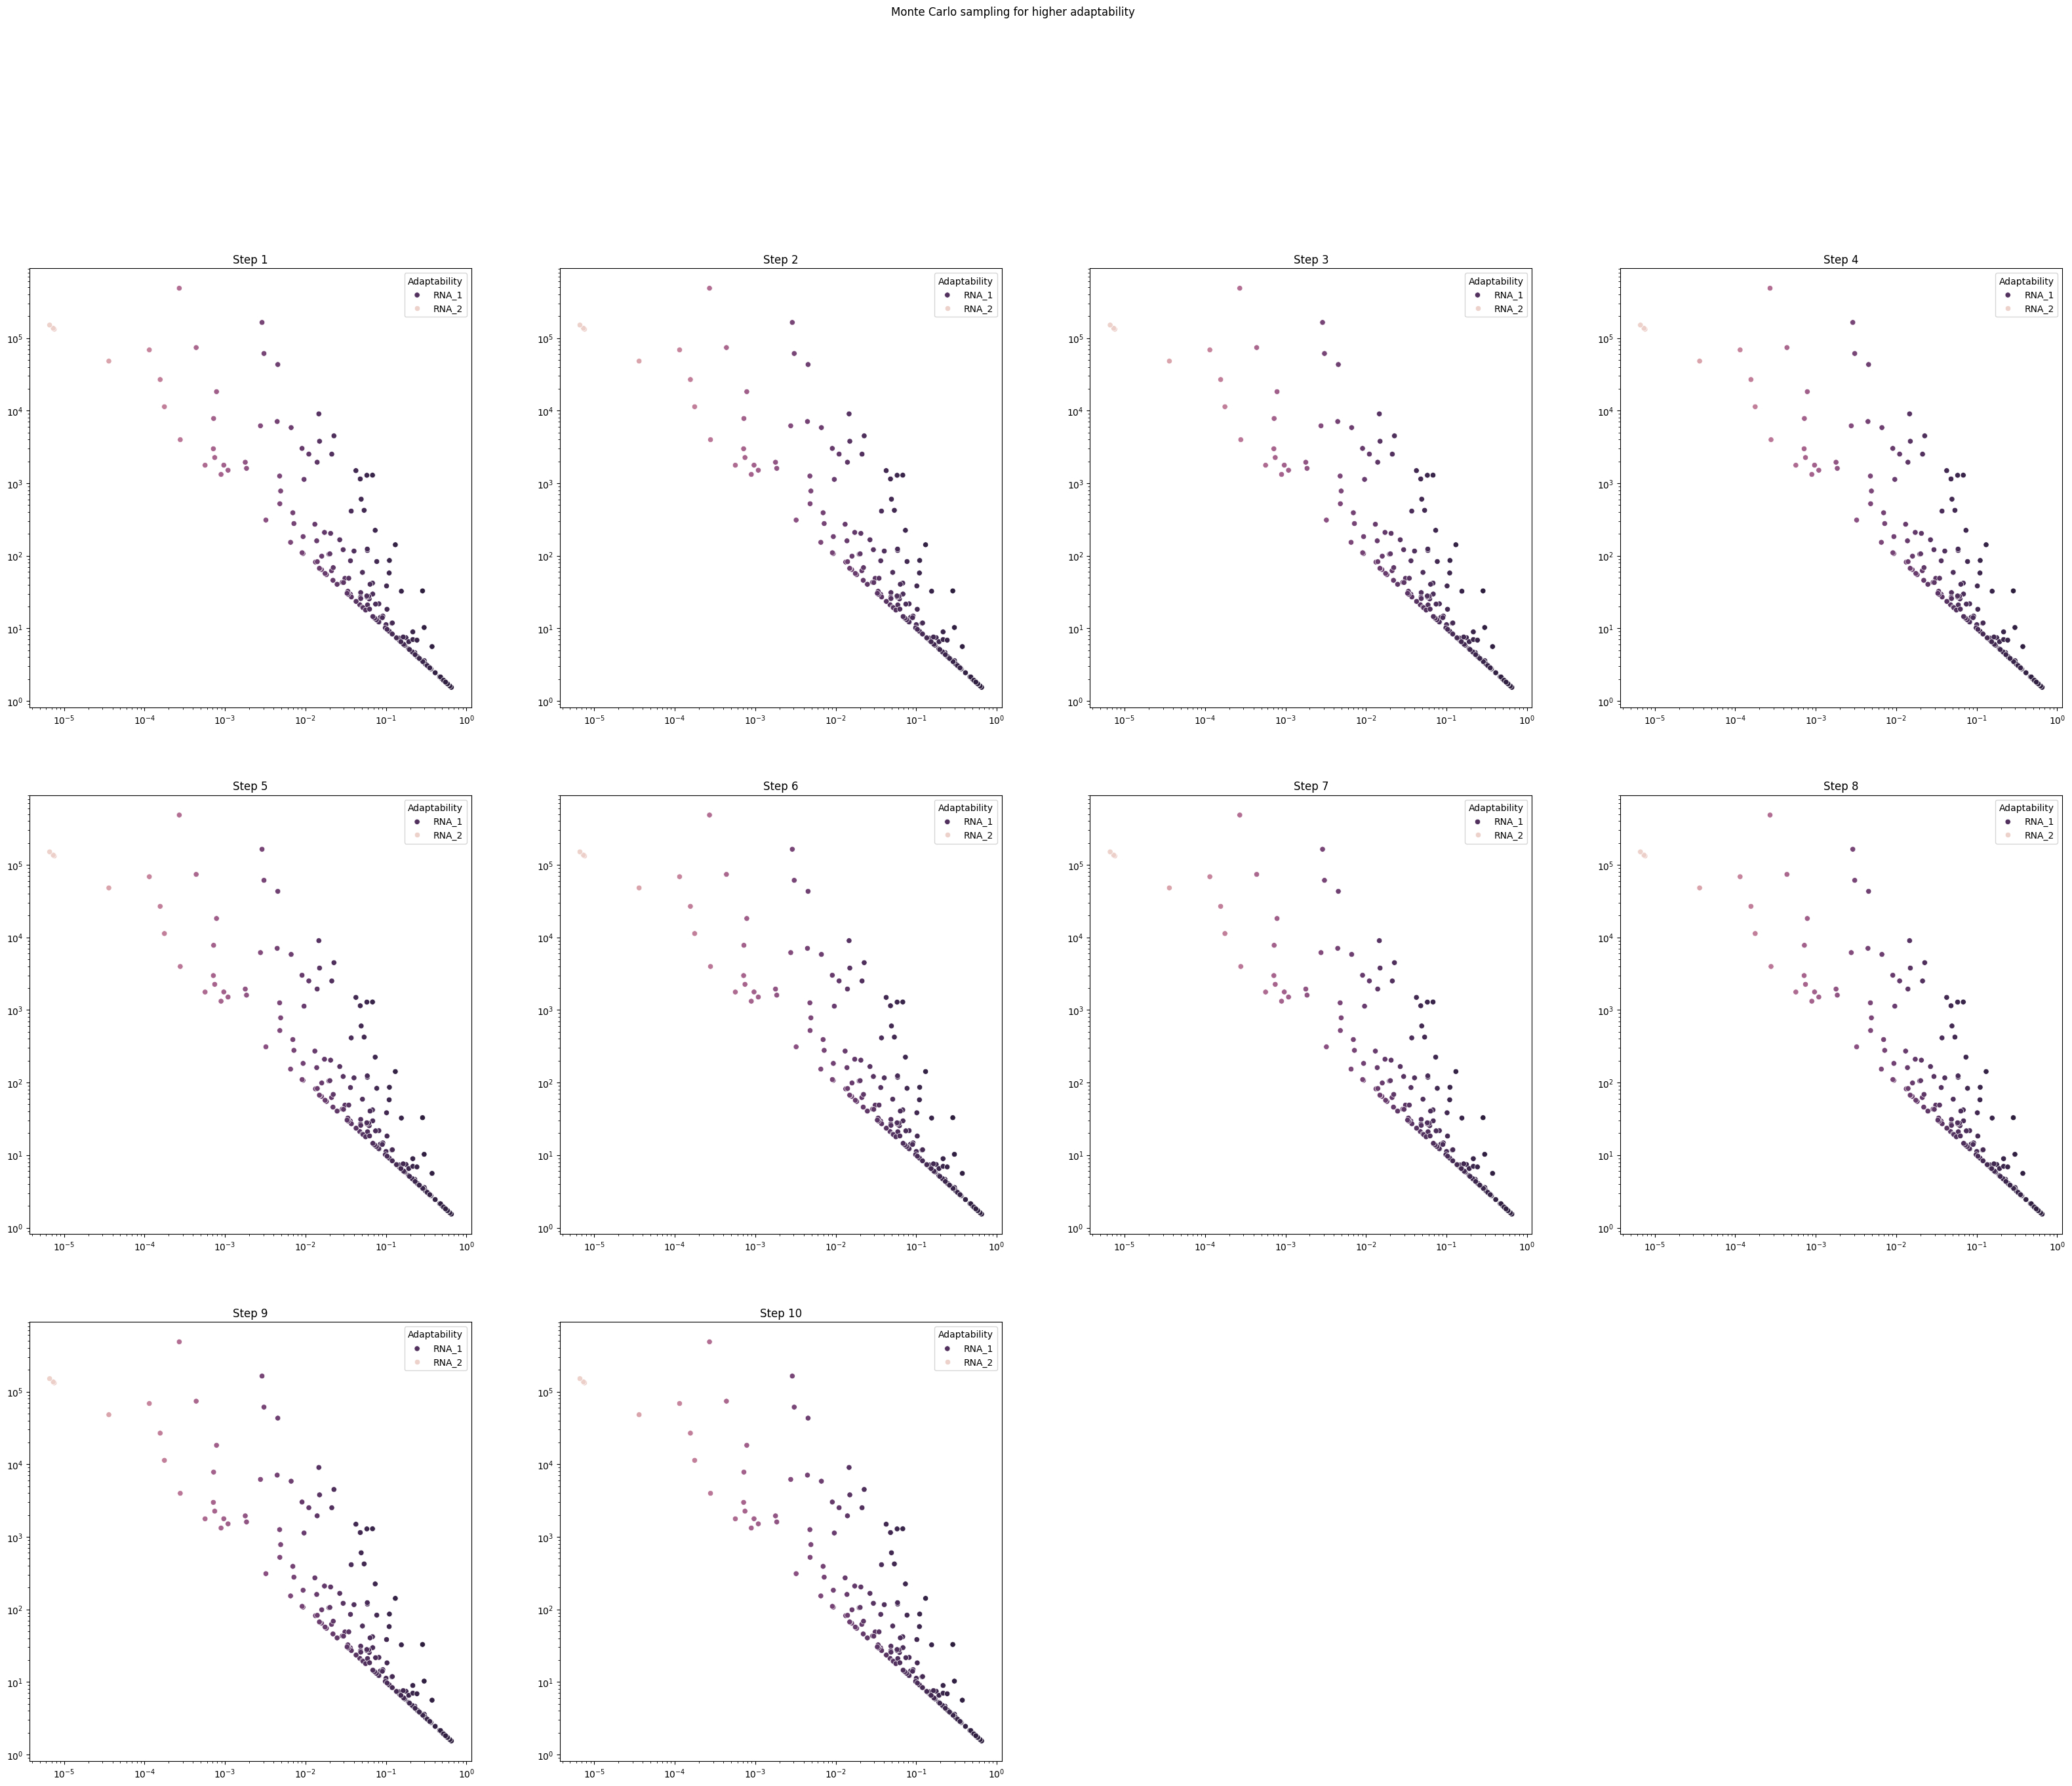

In [9]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(10*nc, 10*nr))
for step, (a, s, p) in enumerate(zip(adaptability_all, sensitivity_all, precision_all)):
    print(f'Maxima - Adaptability: {a.max()}, Sensitivity: {s.max()}, Precision: {p.max()}')
    
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(x=s[..., idxs_output].flatten(), y=p[..., idxs_output].flatten(), hue=a[..., idxs_output].flatten())
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(species_output, title='Adaptability')
    plt.title(f'Step {step+1}')

plt.suptitle('Monte Carlo sampling for higher adaptability')